# Dangling Nodes in PageRank

This notebook serves as material for my video on Personalized PageRank. You can view this video on my YouTube channel (https://www.youtube.com/@insidelearningmachines). 

In a previous article on my blog (https://insidelearningmachines.com/learn_the_pagerank_algorithm/), I introduced the PageRank algorithm. PageRank is a graph algorithm, that can be used to rate the relative importance of nodes within a graph. Originally, PageRank was developed at Google to serve as the basis for its search engine logic.

The example graph I used in the previous article also included a node with no out-going connections; what is called a *dangling node*. Strictly speaking, the PageRank algorithm isn't defined for such nodes, as the out-degree of each node occures in the denominator of the update rule. Let's now try to properly treat for these nodes.

Let's begin by importing the necessary packages:

In [1]:
import sknetwork as skn
import numpy as np
from typing import Tuple, List
from IPython.display import SVG

And now we can run the notebook from the PageRank post to load in the objects implemented there:

In [2]:
%run Notebook\ XXIX\ Learn\ the\ PageRank\ Algorithm\ with\ 1\ Simple\ Example.ipynb

In [3]:
edges

[('A', 'B'),
 ('B', 'D'),
 ('D', 'A'),
 ('D', 'C'),
 ('A', 'C'),
 ('C', 'A'),
 ('D', 'E'),
 ('F', 'D')]

In [4]:
graph = skn.data.from_edge_list(edges, directed=True)

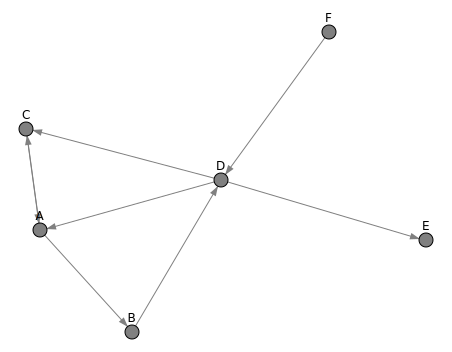

In [5]:
image = skn.visualization.graphs.visualize_graph(adjacency=graph.adjacency, names=graph.names, name_position='above')
SVG(image)

Previously we saw that the PageRank update rule is given by:

${\bf P_r(t+1)} = d{\bf \hat{O}P_r(t)} + \frac{1-d}{N_p}{\bf 1}$

Where: 
* ${\bf P_r(t)}$ is a column vector containing all the page ranks at step $t$
* ${\bf \hat{O}}$ is a modified form of the adacency matrix, where each element $\hat{O}_{i,j}$ is the ratio of edges from $j \rightarrow i$ divided by the total out-degree of node $j$
* ${\bf 1}$ is a column vector consisting of $N_p$ elements.

The modified adacency matrix is given by: ${\bf \hat{O} = OD}$, where ${\bf O}$ is the standard adacency matrix, and ${\bf D}$ is a diagonal matrix with the inverse out-degree of each node.

Let's explore 3 different options for dealing with dangling nodes:
1. **Option 1** : redistribute the probability mass, at the dangling nodes, back to all nodes in the graph
2. **Option 2** : link dangling nodes back to the nodes that link to them
3. **Option 3** : link dangling nodes to themselves, and back to the nodes that link to them

## Option 1

We can modify the update rule above, to accommodate the redistribution of probability mass landing at the dangling nodes in the graph:

${\bf P_r(t+1)} = d\left[{\bf \hat{O}P_r(t)} + \frac{m(t)}{N_p}\right] + \frac{1-d}{N_p}{\bf 1}$

where $m(t)$ is the net probability mass at the dangling nodes at iteration $t$. You can see more information on this here: https://www.dcs.bbk.ac.uk/~dell/teaching/cc/book/ditp/ditp_ch5_3.pdf

In [6]:
class PageRankWithDanglingNodes(PageRank):

    def _step(self, P1: np.array, I: np.array, graph: Graph) -> np.array:
        # detect dangling nodes in the graph & record the respective pageranks
        dangling_nodes_indices = np.where(np.sum(graph.get_modified_adjacency_matrix(),axis=0) == 0)[0].tolist()
        net_probability_at_dangling_nodes = np.sum(P1[dangling_nodes_indices])
        # compute the new pageranks
        N = graph.get_number_nodes()
        P2 = (
            self.damping_factor*(np.matmul(graph.get_modified_adjacency_matrix(),P1) + net_probability_at_dangling_nodes/N)
            + (1 - self.damping_factor)*I/N
        )
        return(P2/np.sum(P2))

In [7]:
# create a graph object
graph = Graph(edges)

In [8]:
# create a pagerank object
pr = PageRankWithDanglingNodes()

In [9]:
# compute pageranks
ranks = pr.evaluate(graph)

In [10]:
ranks

{'A': 0.28179735791394,
 'B': 0.15854751460540928,
 'C': 0.21706013038330138,
 'D': 0.20651511056758282,
 'E': 0.09729625115382935,
 'F': 0.038783635375937243}

## Option 2

In this scenario, we identify the dangling nodes, and then connect them back to the nodes that link to them.

In [11]:
class GraphWithDanglingNodesOption2(Graph):

    def __init__(self, edges: List[Tuple]) -> None:
        # process dangling nodes
        nodes, src_nodes = set(), set()
        for edge in edges:
            nodes.update(list(edge))
            src_nodes.update(edge[0])
        dangling_nodes = nodes.difference(src_nodes)
        new_edges = [(edge[1],edge[0]) for edge in edges if edge[1] in dangling_nodes]
        augmented_edges = edges.copy()
        augmented_edges.extend(new_edges)
        # call the base class initializer
        super().__init__(augmented_edges)

In [12]:
# create a graph object
graph = GraphWithDanglingNodesOption2(edges)

In [13]:
graph.edges

[('A', 'B'),
 ('B', 'D'),
 ('D', 'A'),
 ('D', 'C'),
 ('A', 'C'),
 ('C', 'A'),
 ('D', 'E'),
 ('F', 'D'),
 ('E', 'D')]

In [14]:
# create a pagerank object
pr = PageRank()

In [15]:
# compute pageranks
ranks = pr.evaluate(graph)

In [16]:
ranks

{'A': 0.27618947060566906,
 'B': 0.14238052355314793,
 'C': 0.21274053523551398,
 'D': 0.24832945892330296,
 'E': 0.09536001168236606,
 'F': 0.025000000000000005}

## Option 3

Like before, here we identify the dangling nodes, and then add 2 new edges per dangling node: 
1. one edge that connects the dangling nodes back to the nodes that link to them
2. one edge that connects the dangling nodes to themselves

In [17]:
class GraphWithDanglingNodesOption3(Graph):

    def __init__(self, edges: List[Tuple]) -> None:
        # process dangling nodes
        nodes, src_nodes = set(), set()
        for edge in edges:
            nodes.update(list(edge))
            src_nodes.update(edge[0])
        dangling_nodes = nodes.difference(src_nodes)
        new_edges = [(edge[1],edge[1]) for edge in edges if edge[1] in dangling_nodes]
        new_edges.extend([(edge[1],edge[0]) for edge in edges if edge[1] in dangling_nodes])
        augmented_edges = edges.copy()
        augmented_edges.extend(new_edges)
        # call the base class initializer
        super().__init__(augmented_edges)

In [18]:
# create a graph object
graph = GraphWithDanglingNodesOption3(edges)

In [19]:
graph.edges

[('A', 'B'),
 ('B', 'D'),
 ('D', 'A'),
 ('D', 'C'),
 ('A', 'C'),
 ('C', 'A'),
 ('D', 'E'),
 ('F', 'D'),
 ('E', 'E'),
 ('E', 'D')]

In [20]:
# compute pageranks
ranks = pr.evaluate(graph)

In [21]:
ranks

{'A': 0.2586315496119937,
 'B': 0.1349184068419662,
 'C': 0.19921619058765377,
 'D': 0.22693335865656059,
 'E': 0.15530049430182583,
 'F': 0.025000000000000005}

## Results

Node | Original PageRank | Option 1 | Option 2 | Option 3 | sknetwork PageRank
--- | --- | --- | --- | --- | ---
A | 0.295 | 0.282 | 0.276 | 0.259 | 0.247
B | 0.163 | 0.158 | 0.142 | 0.135 | 0.137
C | 0.224 | 0.217 | 0.213 | 0.199 | 0.189
D | 0.202 | 0.206 | 0.248 | 0.227 | 0.172
E | 0.089 | 0.097 | 0.095 | 0.155 | 0.227
F | 0.027 | 0.039 | 0.025 | 0.025 | 0.026

Which option makes the most sense? 

Keep in mind we have kept the damping factor at $d = 0.85$. How do the results change if we alter this value?